# Trained gradient boosting regression versus linear statistical models 

##### Some things to note:

1.This notebook highlights multiple processes that are prevalent in data science: cleaning *dirty* data , data exploration, pipeline model creation/usage, hyperparameter optimization via GridSearchCV and visual modeling. The purpose is of this notebook is to showcase these different process as well as to display the differences in computing accuracy between a trained gradient boosting regression model versus linear statistical models.  

2.There are flaws to this model: the listings.csv dataset is comprised of <b>LISTINGS</b> data, NOT transaction data. Therefore, this notebook only expands on the supply side discourse of AirBnB listings. However, it can be replicated with transactional data to gauge for consumer preferences. 

by Angelo Cortez (UC Irvine '17 Economics / ICS) 


## General comparison:

<img src="static/comparison.png">


| Gradient boosting regression | Linear regression |
| ------------- |:-----------------:|
| (-) computationally expensive      | (+) computationally inexpensive   |
| (+) very accurate   | (-) not too accurate         |
| (-) hard to interpret | (+) very interpretable        | 

<h3>Step 1: Clean the data of null values.</h3>

In [28]:
import numpy as np
import pandas as pd


tyo=pd.read_csv('listings.csv')
tyo.dropna(axis=0, how='all', inplace=True)

# Then we import our listings file. We do not want to see blank rows, so we shall delete them with the .dropna method
# We want to see if there are any duplicates in the dataframe. We can achieve this by comparing listing ID's.
# By using the lambda method below, we can extract the id in the URL, then by applying the .drop_duplciates() method,
# we can find delete those with duplicate url's. 

tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

# We want to reconstruct the Entire_home/apt feature and the book_instantly with dummy variables. 
# This is achievable by using the .map function.

tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})
tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)

# We don't need the url feature. 
tyo.drop('url', axis=1, inplace=True)

# We can also take care of dummies using for loops!

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


# Dropping the cancel policy sice it is uninteresting. 

tyo.drop('cancel_policy',axis=1, inplace=True) 

tyo.drop(0, axis=0, inplace=True)
tyo.drop('room_type', axis=1, inplace = True)
X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price
# Set X and Y variables here. 


<h3> Pearson's r correlation matrix </h3>

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

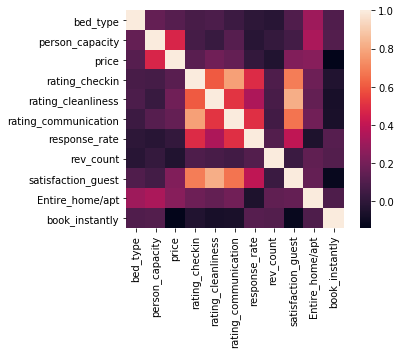

In [32]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables. 
# We can see that the most correlated to price is the person capacity of a listing. 

pears= tyo.drop(['amenities','response_time'], axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
corr_matrix = pears.corr()
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

<h3>Scatter plot of listing price vs person capacity</h3>

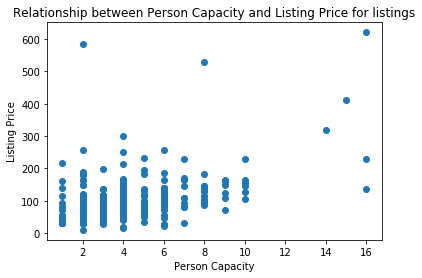

In [33]:
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capacity and Listing Price for listings")
plt.show()

<h3>Tip: Checking for the amount of null values for every column</h3>

In [34]:
X.isnull().sum().sort_values(ascending=False)

satisfaction_guest      28
rating_communication    28
rating_cleanliness      28
rating_checkin          28
accuracy                28
response_rate           20
book_instantly           0
Entire_home/apt          0
rev_count                0
person_capacity          0
bed_type                 0
dtype: int64

<h3> Step 2: Creating our pipeline for gradient boosting regression  </h3>

In [35]:
def show_best(grid_pipe):
    print(f'Best params: {grid_pipe.best_params_} \n\nBest score: {-1*grid_pipe.best_score_} \n Best estimator: {grid_pipe.best_estimator_}')

In [36]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


In [37]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [41]:

pipeline3 = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', GradientBoostingRegressor())
])

tuned_parameters = {
    "rgr__n_estimators":      [ n for n in range(80,200,10)],
    "rgr__max_depth" :        [ 3  ],
    "rgr__learning_rate":     [   0.1, .05, .15],
    "rgr__min_samples_split" :[  6    ],
    "rgr__loss" :             [ 'ls', 'lad' ],
    "rgr__max_features":      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}

noScalePipe = GridSearchCV(pipeline3, tuned_parameters, cv=5, scoring='neg_median_absolute_error')
noScalePipe.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_de...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rgr__n_estimators': [80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'rgr__max_depth': [3], 'rgr__learning_rate': [0.1, 0.05, 0.15], 'rgr__min_samples_split': [6], 'rgr__loss': ['ls', 'lad'], 'rgr__max_features': [1.0, 0.8, 0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [42]:
show_best(noScalePipe)

Best params: {'rgr__learning_rate': 0.15, 'rgr__loss': 'lad', 'rgr__max_depth': 3, 'rgr__max_features': 0.3, 'rgr__min_samples_split': 6, 'rgr__n_estimators': 170} 

Best score: 14.150762238579295 
 Best estimator: Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='lad', max_depth=3, max_features=0.3,
             max_leaf_nodes=None, min_impurity_d...s=170, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])


Now we instantiate the GBRegressor into a new pipeline so we can extract feature importances from it (scikit-learn deos not allow us to extract feature importances from a gridsearched pipeline). 

In [43]:
gbt = GradientBoostingRegressor(learning_rate = 0.05,
                               loss = 'ls',
                               max_depth = 3,
                               max_features = 1.0,
                               min_samples_split = 6,
                                n_estimators = 190)
pipeline = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', gbt)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=1.0,
             max_leaf_nodes=None, min_impurity_de...s=190, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

<h3> Step 3: Extract feature importances </h3>

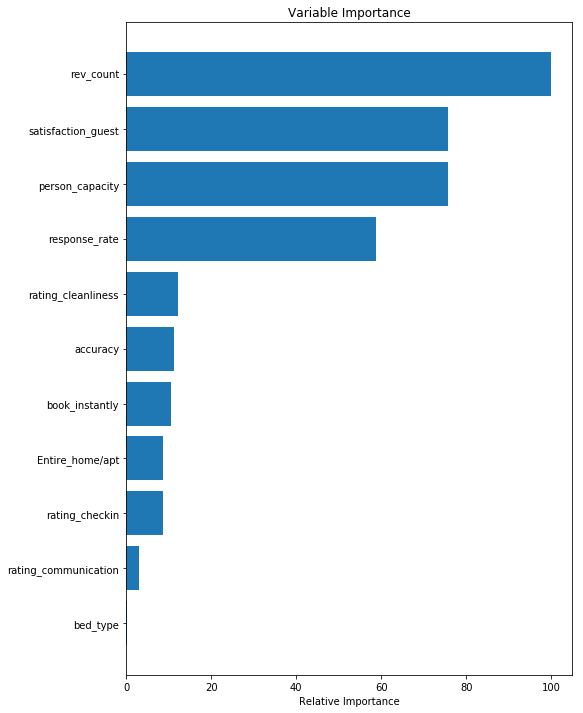

In [44]:
feature_importance = gbt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

#As expected, person capacity was the most important variable when predicting price

<li> We can see that the median absolute error was around $14 with the GBRegressor and the most important feature when it came to predicting price was the number of reviews of a listing. Now let's compare it to linear statistical models below.</li>

<h3> Step 4: Compare the MAE (median absolute accuracy) accuracy  with other statistical models.  </h3>

In [45]:
imp = Imputer(missing_values='NaN', strategy = 'median', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[ 22.43590597  22.2955814   19.09626037  19.42072797  19.69915185
  23.7814173   19.23620839  19.62987255  20.77738353  22.43590597]


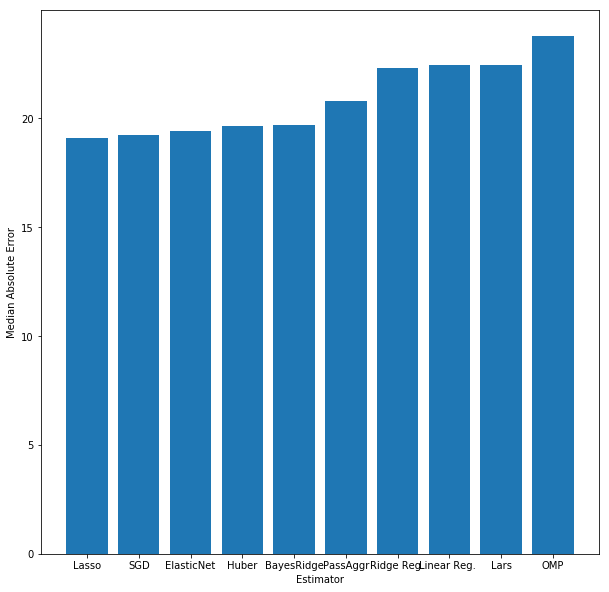

In [46]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit(), linear_model.SGDRegressor(),
       linear_model.HuberRegressor(), linear_model.PassiveAggressiveRegressor(), linear_model.Lars()]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP', 'SGD', 
                        'Huber', 'PassAggr', 'Lars'])
errvals = np.array([])


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print("got error %0.2f" % this_err)
    errvals = np.append(errvals, this_err)

    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,len(ests_labels)))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression


<li> The graph above shows that other untuned statistical estimators gave us a median absolute error rate of around 19 to 23. At a median absoerror of about 14 dollars, we can conclude that gradient boosting regressor serves as a more accurate estimator.  </li>